<a href="https://colab.research.google.com/github/CheilaBaiao/GEE_SR/blob/main/Pantanal_NDVI_P%C3%B3sProcessamento_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =========================
# PÓS-PROCESSAMENTO OFFLINE
# NDVI mensal (12 bandas/ano) → 1º break por pixel
# Saídas: CSVs + plots (sem salvar GeoTIFF)
# =========================

!pip -q install rasterio numpy pandas ruptures matplotlib



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 114.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.1 MB/s eta 0:00:00


In [ ]:
# ---------- Imports ----------
import os, re, math, gc
from pathlib import Path
import numpy as np
import pandas as pd
import rasterio as rio
from rasterio.windows import Window
import ruptures as rpt
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')  # use o padrão
print("Drive montado!")

Mounted at /content/drive
Drive montado!


In [ ]:
from pickle import FALSE
# ---------- Parâmetros principais ----------
INPUT_DIR  = Path("/content/drive/MyDrive/Pantanal_TippingPoints")  # pasta com os TIFFs anuais
OUT_DIR    = Path("/content/drive/MyDrive/Pantanal_TippingPoints_OFFLINE")  # saídas
OUT_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR  = OUT_DIR / "plots"
PLOTS_DIR.mkdir(exist_ok=True)

# Padrão para capturar o ANO no nome do arquivo (ajuste se necessário)
# Ex.: Pantanal_1985.tif, NDVI_1985_12bands.tif, etc.
YEAR_REGEX = re.compile(r"(19|20)\d{2}")

# Dados e controle
DATA_SCALE     = 10000.0       # NDVI foi salvo como Int16 * 10000
NODATA         = -32768
TILE_PX        = 64            # janela de processamento (pixels) — ajuste 32/64/96
VALID_FRAC_MIN = 0.02          # pula tiles com <2% de válidos
RUN_SAMPLE_ONLY = False         # True: roda amostra; False: roda tudo
SAMPLE_N_TILES  = 20           # nº de tiles na amostra
TOP_N_PLOTS     = 10           # nº de tiles (maior frac_breaks) para plotar

# Ruptures
MODEL_RUPTURES = "l2"          # "l2" é leve e bom após dessazonalizar
MIN_POINTS     = 36            # mínimo de pontos válidos para tentar detectar 1 quebra

In [ ]:
# ---------- Utilitários ----------
def list_year_files(input_dir: Path):
    files = sorted([f for f in input_dir.glob("*.tif") if f.is_file()])
    pairs = []
    for f in files:
        m = YEAR_REGEX.search(f.name)
        if m:
            pairs.append((int(m.group()), f))
    pairs = sorted(pairs, key=lambda x: x[0])
    if not pairs:
        raise RuntimeError("Não encontrei GeoTIFFs anuais no diretório informado.")
    years, paths = zip(*pairs)
    return list(years), list(paths)

def check_alignment(ref_ds, other_ds):
    same = (
        ref_ds.crs == other_ds.crs and
        ref_ds.transform == other_ds.transform and
        ref_ds.width == other_ds.width and
        ref_ds.height == other_ds.height and
        ref_ds.count == ref_ds.count  # só para simetria; deixamos checar bandas à parte
    )
    return same

def month_index_to_ym(idx, years):
    """Mapeia índice 0..(len(years)*12-1) para (YYYY, MM)."""
    y = years[idx // 12]
    m = 1 + (idx % 12)
    return int(y), int(m)

def _fill_na_linear_1d(x: np.ndarray):
    idx = np.arange(x.size)
    good = np.isfinite(x)
    if good.sum() < 2:
        return None
    return np.interp(idx, idx[good], x[good])

def deseasonalize_series_matrix(mat_2d, n_years):
    """mat_2d shape: (Npix, T) com T = 12*n_years; retorna mesma shape."""
    T = mat_2d.shape[1]
    assert T == n_years * 12, "Esperava T múltiplo de 12."
    out = mat_2d.copy()
    # climatologia por mês (média por coluna m::12)
    for m in range(12):
        cols = np.arange(m, T, 12)
        clim = np.nanmean(out[:, cols], axis=1, keepdims=True)
        out[:, cols] = out[:, cols] - clim
    return out

'''def first_break_1d(ts: np.ndarray, model=MODEL_RUPTURES):
    x = _fill_na_linear_1d(ts.astype("float32"))
    if x is None or np.isfinite(x).sum() < MIN_POINTS:
        return -1
    try:
        bkps = rpt.Binseg(model=model).fit(x).predict(n_bkps=1)
        bp = bkps[0] - 1 if bkps and bkps[0] < len(x) else -1
        return int(bp)
    except Exception:
        return -1'''

def first_break_1d(ts: np.ndarray,
                   model=MODEL_RUPTURES,
                   min_points=MIN_POINTS,
                   min_delta=0.03,   # NDVI mínimo de salto (ex.: 0.03–0.05)
                   min_r2=0.10):     # ganho mínimo relativo (10%)
    x = _fill_na_linear_1d(ts.astype("float32"))
    if x is None or np.isfinite(x).sum() < min_points:
        return -1
    x = x - np.nanmean(x)            # centraliza p/ estabilidade numérica
    T = len(x)

    try:
        algo = rpt.Binseg(model=model).fit(x)
        bkps = algo.predict(n_bkps=1)              # candidato
        if not bkps:
            return -1
        k = int(bkps[0])
        if k <= 1 or k >= T:                        # corte inválido
            return -1

        mu1 = float(np.nanmean(x[:k]))
        mu2 = float(np.nanmean(x[k:]))
        delta = abs(mu1 - mu2)

        ssr0 = float(np.nansum((x - np.nanmean(x))**2))
        ssr1 = float(np.nansum((x[:k] - mu1)**2) + np.nansum((x[k:] - mu2)**2))
        r2   = (ssr0 - ssr1) / (ssr0 + 1e-12)

        # só aceita break se for “grande o suficiente”
        if (delta >= min_delta) and (r2 >= min_r2):
            return k - 1              # índice do 1º mês do novo regime
        else:
            return -1
    except Exception:
        return -1

def tile_bounds(transform, col_off, row_off, width, height):
    """BBox do tile (em CRS do raster)."""
    x0, y0 = transform * (col_off, row_off)
    x1, y1 = transform * (col_off + width, row_off + height)
    # lembrar: y decresce para baixo; ajustar min/max:
    minx, maxx = min(x0, x1), max(x0, x1)
    miny, maxy = min(y0, y1), max(y0, y1)
    return minx, miny, maxx, maxy

In [ ]:
# ---------- Carregar metadados e validar ----------
years, paths = list_year_files(INPUT_DIR)
n_years = len(years)
print(f"Arquivos anuais encontrados: {n_years} ({years[0]}–{years[-1]})")

datasets = [rio.open(p) for p in paths]
ref = datasets[0]
print("CRS:", ref.crs)
print("Tamanho (px):", ref.width, "x", ref.height, "| bandas (esperado 12):", ref.count)
for ds in datasets[1:]:
    if not check_alignment(ref, ds):
        # Para aula, é melhor travar do que resamplar sem explicar
        for d in datasets: d.close()
        raise RuntimeError(f"Alinhamento diferente em {ds.name}. "
                           "Reexporte garantindo mesmo CRS, transform, resolução e extent.")
if ref.count != 12:
    for d in datasets: d.close()
    raise RuntimeError("Cada TIFF anual deve ter 12 bandas (meses). Verifique suas exportações.")

width, height = ref.width, ref.height
transform = ref.transform
# Nota: manter arquivos abertos (40) é ok; rasterio gerencia.

Arquivos anuais encontrados: 40 (1985–2024)
CRS: EPSG:3857
Tamanho (px): 1614 x 2558 | bandas (esperado 12): 12


In [ ]:
# ---------- Iterador de janelas (tiles em px) ----------
def iter_windows(w, h, tile_px=TILE_PX):
    tid = 0
    for row_off in range(0, h, tile_px):
        for col_off in range(0, w, tile_px):
            tid += 1
            win_w = min(tile_px, w - col_off)
            win_h = min(tile_px, h - row_off)
            yield tid, Window(col_off, row_off, win_w, win_h), (col_off, row_off, win_w, win_h)

In [ ]:
# ---------- Processar UMA janela ----------
def process_window(tid, win):
    # Lê todos os anos (12 bandas) para a janela → cube shape (T, H, W)
    chunks = []
    for ds in datasets:
        arr = ds.read(indexes=list(range(1, 13)), window=win)  # (12, h, w)
        arr = arr.astype("float32")
        mask = (arr == NODATA)
        arr[~mask] = arr[~mask] / DATA_SCALE
        arr[mask] = np.nan
        chunks.append(arr)
    cube = np.concatenate(chunks, axis=0)  # (T=12*n_years, h, w)

    # Pular tiles vazios/escassos
    valid_frac = np.isfinite(cube).sum() / cube.size
    if valid_frac < VALID_FRAC_MIN:
        return {"tile_id": tid, "skipped": True}, None, None

    # Ruptures por pixel
    T, h, w = cube.shape
    flat = cube.reshape(T, -1).T  # (Npix, T)
    flat_ds = deseasonalize_series_matrix(flat, n_years=n_years)

    mask_valid = (np.isfinite(flat).sum(axis=1) >= MIN_POINTS)
    n_valid_pixels = int(mask_valid.sum())

    bp = np.full(flat.shape[0], -1, dtype=np.int32)
    for i in range(flat.shape[0]):
        bp[i] = first_break_1d(flat_ds[i, :], model=MODEL_RUPTURES)
    bp = bp.reshape(h, w)

    # Agregações por tile
    mask_bp = bp >= 0
    n_pixels = h * w
    n_break  = int(mask_bp.sum())
    frac     = (n_break / n_pixels) if n_pixels else 0.0

    # converter índices → ano/mês
    v = bp[mask_bp].ravel()
    years_v  = np.array([years[k // 12] for k in v], dtype=np.int32)
    months_v = np.array([1 + (k % 12) for k in v], dtype=np.int32)
    yyyymm_v = years_v * 100 + months_v

    # bbox do tile
    col_off, row_off, win_w, win_h = win.col_off, win.row_off, win.width, win.height
    minx, miny, maxx, maxy = tile_bounds(transform, col_off, row_off, win_w, win_h)

    # estatísticas do tile
    earliest = int(yyyymm_v.min()) if yyyymm_v.size else 0
    latest   = int(yyyymm_v.max()) if yyyymm_v.size else 0
    modal_year   = int(pd.Series(years_v).mode().iloc[0])  if years_v.size  else 0
    modal_yyyymm = int(pd.Series(yyyymm_v).mode().iloc[0]) if yyyymm_v.size else 0

    summary = {
        "tile_id": tid,
        "minx": minx, "miny": miny, "maxx": maxx, "maxy": maxy,
        "n_pixels": n_pixels, "n_break_pixels": n_break,
        "frac_breaks": frac,
        "earliest_yyyymm": earliest, "latest_yyyymm": latest,
        "modal_year": modal_year, "modal_yyyymm": modal_yyyymm,
        "n_valid_pixels": n_valid_pixels,
        "frac_breaks_valid": (n_break / max(n_valid_pixels, 1))
    }

    # contagens
    by_year = {}
    by_ym   = {}
    if years_v.size:
        y_u, c_y = np.unique(years_v,  return_counts=True)
        for yi, ci in zip(y_u, c_y): by_year[int(yi)] = int(ci)
    if yyyymm_v.size:
        ym_u, c_ym = np.unique(yyyymm_v, return_counts=True)
        for ymi, ci2 in zip(ym_u, c_ym): by_ym[int(ymi)] = int(ci2)

    return summary, by_year, by_ym

In [ ]:
# ---------- Rodar AMOSTRA (20 tiles) ----------
summaries = []
rows_year = []
rows_ym   = []

print(f"Rodando AMOSTRA de {SAMPLE_N_TILES} tiles para conferência...")
count_done = 0
for tid, win, _ in iter_windows(width, height, TILE_PX):
    summary, by_year, by_ym = process_window(tid, win)
    if summary is None:
        continue
    if not summary.get("skipped", False):
        summaries.append(summary)
        for y, c in (by_year or {}).items():
            rows_year.append({"tile_id": summary["tile_id"], "year": y, "count": c})
        for ym, c in (by_ym or {}).items():
            rows_ym.append({"tile_id": summary["tile_id"], "yyyymm": ym, "count": c})
    count_done += 1
    if count_done >= SAMPLE_N_TILES:
        break

df_sum_s  = pd.DataFrame(summaries)
df_year_s = pd.DataFrame(rows_year)
df_ym_s   = pd.DataFrame(rows_ym)

print("\n=== AMOSTRA: resumo por tile (top 10 por frac_breaks) ===")
if not df_sum_s.empty:
    print(df_sum_s.sort_values("frac_breaks", ascending=False).head(10).to_string(index=False))
else:
    print("(sem tiles válidos na amostra; ajuste TILE_PX, VALID_FRAC_MIN ou confirme os dados)")

print("\n=== AMOSTRA: contagem por ano (primeiras linhas) ===")
if not df_year_s.empty:
    print(df_year_s.sort_values(["tile_id","year"]).head(10).to_string(index=False))
else:
    print("(sem dados)")

print("\n=== AMOSTRA: contagem por ano-mês (primeiras linhas) ===")
if not df_ym_s.empty:
    print(df_ym_s.sort_values(["tile_id","yyyymm"]).head(10).to_string(index=False))
else:
    print("(sem dados)")


Rodando AMOSTRA de 20 tiles para conferência...


/tmp/ipython-input-1682515892.py:46: RuntimeWarning: Mean of empty slice
  clim = np.nanmean(out[:, cols], axis=1, keepdims=True)
/tmp/ipython-input-1682515892.py:46: RuntimeWarning: Mean of empty slice
  clim = np.nanmean(out[:, cols], axis=1, keepdims=True)
/tmp/ipython-input-1682515892.py:46: RuntimeWarning: Mean of empty slice
  clim = np.nanmean(out[:, cols], axis=1, keepdims=True)
/tmp/ipython-input-1682515892.py:46: RuntimeWarning: Mean of empty slice
  clim = np.nanmean(out[:, cols], axis=1, keepdims=True)
/tmp/ipython-input-1682515892.py:46: RuntimeWarning: Mean of empty slice
  clim = np.nanmean(out[:, cols], axis=1, keepdims=True)



=== AMOSTRA: resumo por tile (top 10 por frac_breaks) ===
 tile_id       minx       miny       maxx       maxy  n_pixels  n_break_pixels  frac_breaks  earliest_yyyymm  latest_yyyymm  modal_year  modal_yyyymm  n_valid_pixels  frac_breaks_valid
       8 -6449400.0 -1782900.0 -6430200.0 -1763700.0      4096              99     0.024170           199108         201407        2008        200804            2535           0.039053
       9 -6430200.0 -1782900.0 -6411000.0 -1763700.0      4096              99     0.024170           199701         201603        2008        200804            1053           0.094017
      19 -6238200.0 -1782900.0 -6219000.0 -1763700.0      4096              87     0.021240           200804         201407        2012        201206             585           0.148718
       7 -6468600.0 -1782900.0 -6449400.0 -1763700.0      4096              66     0.016113           199907         202206        2013        200510             696           0.094828
      10 -641100

In [ ]:
# ---------- Rodar TODOS (com tempo, ETA e resumo) ----------
# ===== Rodar com CHECKPOINT por tile (robusto) =====
import time, math, json, os
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm

CKPT_DIR   = OUT_DIR / "checkpoints"
CKPT_DIR.mkdir(exist_ok=True)

CSV_SUM  = OUT_DIR / "tiles_with_breaks.csv"
CSV_YEAR = OUT_DIR / "breaks_by_tile_year.csv"
CSV_YM   = OUT_DIR / "breaks_by_tile_yyyymm.csv"
DONE_TXT = CKPT_DIR / "done_tiles.txt"   # lista de tile_id já processados

# --- 1) Carrega "done" de rodadas anteriores (checkpoint) ---
done = set()
if DONE_TXT.exists():
    with open(DONE_TXT) as f:
        done |= {int(x.strip()) for x in f if x.strip().isdigit()}

# Também considera tiles já presentes no CSV_SUM (evita duplicar se caiu antes de gravar DONE_TXT)
if CSV_SUM.exists():
    try:
        prev = pd.read_csv(CSV_SUM, usecols=["tile_id"])
        done |= set(int(x) for x in prev["tile_id"].tolist())
    except Exception:
        pass

print(f"Tiles já feitos (checkpoint): {len(done)}")

def append_df(df, path):
    import os
    if df is None or df.empty:
        return
    path.parent.mkdir(parents=True, exist_ok=True)
    header = (not path.exists()) or (os.path.getsize(path) == 0)
    df.to_csv(path, mode="a", header=header, index=False)

if not RUN_SAMPLE_ONLY:
    total_tiles = sum(1 for tid,_,_ in iter_windows(width, height, TILE_PX) if tid not in done)
    pbar = tqdm(total=total_tiles, desc="Tiles (resume)", unit="tile")
    T0 = time.perf_counter()
    skipped = 0

    for tid, win, _ in iter_windows(width, height, TILE_PX):
        if tid in done:
            continue

        t0 = time.perf_counter()
        summary, by_year, by_ym = process_window(tid, win)

        # 2) Grava imediatamente resultados deste tile (append)
        if summary and not summary.get("skipped", False):
            append_df(pd.DataFrame([summary]), CSV_SUM)
            if by_year:
                rows_y = [{"tile_id": summary["tile_id"], "year": y, "count": c} for y, c in by_year.items()]
                append_df(pd.DataFrame(rows_y), CSV_YEAR)
            if by_ym:
                rows_m = [{"tile_id": summary["tile_id"], "yyyymm": ym, "count": c} for ym, c in by_ym.items()]
                append_df(pd.DataFrame(rows_m), CSV_YM)
        else:
            skipped += 1

        # 3) Marca tile como concluído (checkpoint)
        with open(DONE_TXT, "a") as f:
            f.write(f"{tid}\n")
        done.add(tid)

        pbar.update(1)
        pbar.set_postfix(last_s=f"{time.perf_counter()-t0:5.2f}s")

    pbar.close()
    print(f"Tempo desta rodada: {(time.perf_counter()-T0)/60:.1f} min | skipped={skipped}")



Tiles já feitos (checkpoint): 532


Tiles (resume):   0%|          | 0/508 [00:00<?, ?tile/s]

/tmp/ipython-input-1682515892.py:46: RuntimeWarning: Mean of empty slice
  clim = np.nanmean(out[:, cols], axis=1, keepdims=True)
/tmp/ipython-input-1682515892.py:46: RuntimeWarning: Mean of empty slice
  clim = np.nanmean(out[:, cols], axis=1, keepdims=True)
/tmp/ipython-input-1682515892.py:46: RuntimeWarning: Mean of empty slice
  clim = np.nanmean(out[:, cols], axis=1, keepdims=True)
/tmp/ipython-input-1682515892.py:46: RuntimeWarning: Mean of empty slice
  clim = np.nanmean(out[:, cols], axis=1, keepdims=True)
/tmp/ipython-input-1682515892.py:46: RuntimeWarning: Mean of empty slice
  clim = np.nanmean(out[:, cols], axis=1, keepdims=True)
/tmp/ipython-input-1682515892.py:46: RuntimeWarning: Mean of empty slice
  clim = np.nanmean(out[:, cols], axis=1, keepdims=True)
/tmp/ipython-input-1682515892.py:46: RuntimeWarning: Mean of empty slice
  clim = np.nanmean(out[:, cols], axis=1, keepdims=True)
/tmp/ipython-input-1682515892.py:46: RuntimeWarning: Mean of empty slice
  clim = np.nanme

Tempo desta rodada: 94.9 min | skipped=311


In [ ]:
import pandas as pd, os

def snapshot():
    if CSV_SUM.exists():
        df = pd.read_csv(CSV_SUM, usecols=["tile_id","n_break_pixels","frac_breaks"])
        print("linhas no resumo:", len(df), "| tiles distintos:", df["tile_id"].nunique())
        print(df.tail(3))
    else:
        print("Resumo ainda não existe.")

    if CSV_YM.exists():
        dym = pd.read_csv(CSV_YM)
        print("linhas em yyyymm:", len(dym), "| tiles distintos:", dym["tile_id"].nunique())
        print(dym.tail(3))

snapshot()




linhas no resumo: 554 | tiles distintos: 554
     tile_id  n_break_pixels  frac_breaks
551     1022            1306     0.329133
552     1023             470     0.118448
553     1024             100     0.025202
linhas em yyyymm: 13586 | tiles distintos: 547
       tile_id  yyyymm  count
13583     1024  201402      4
13584     1024  201505      1
13585     1024  201912      1


Top para plotar:
      tile_id  modal_yyyymm  frac_breaks
116      189        200304     0.906250
72       137        201407     0.801270
54       111        201201     0.800293
172      255        200804     0.793701
347      515        201407     0.779053
294      435        200804     0.772705
115      188        201402     0.761719
398      591        201407     0.757812
254      377        201103     0.756836
434      644        200804     0.753418


/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:1233: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,


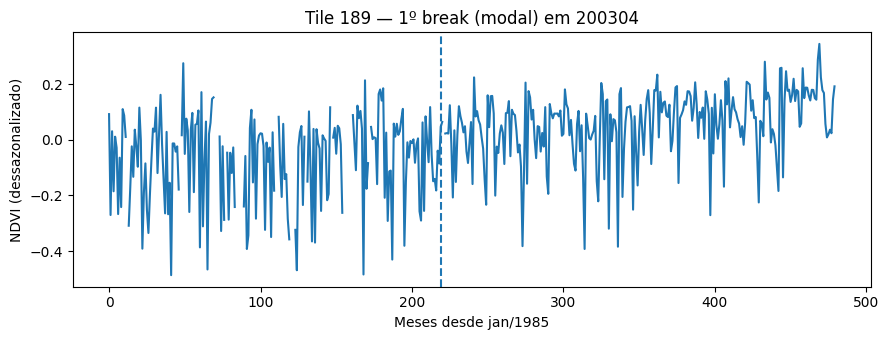

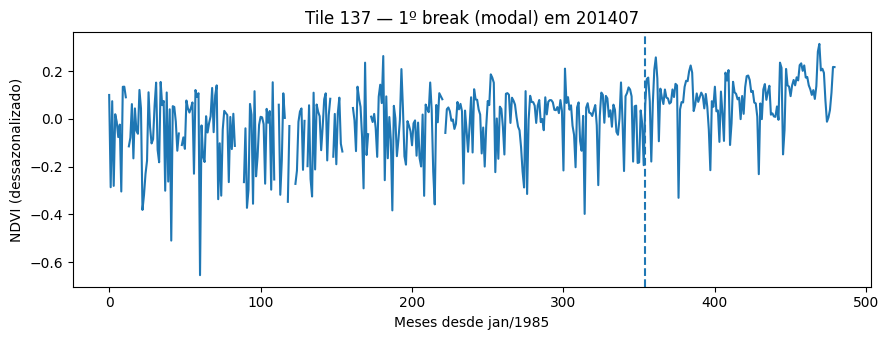

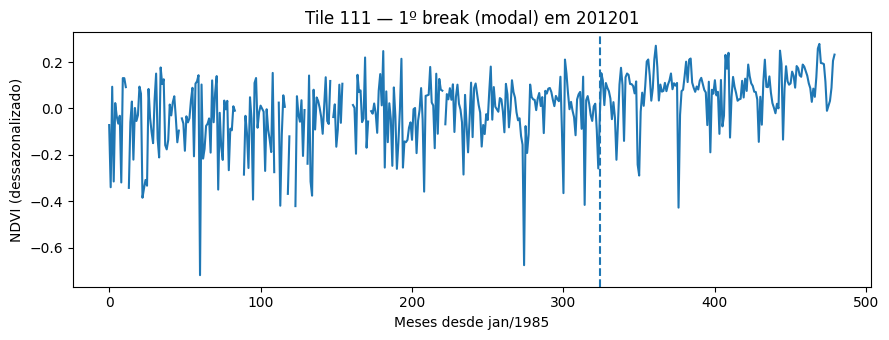

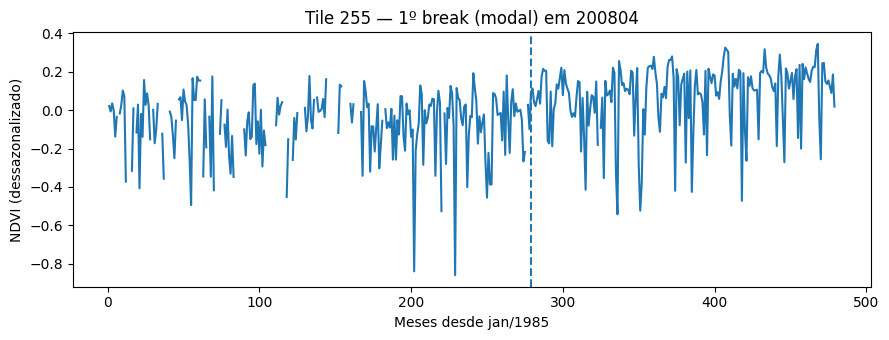

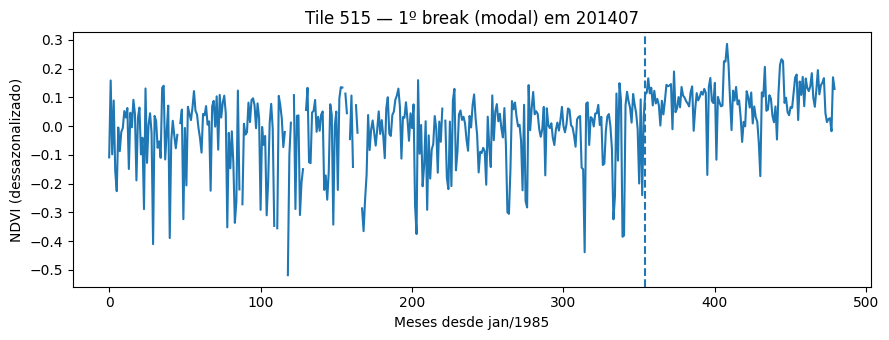

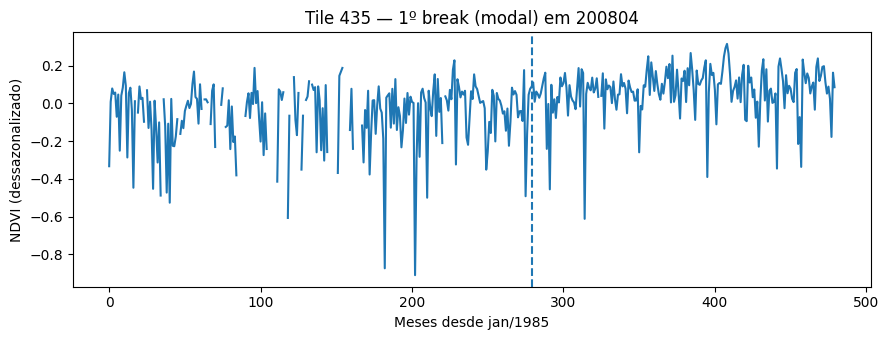

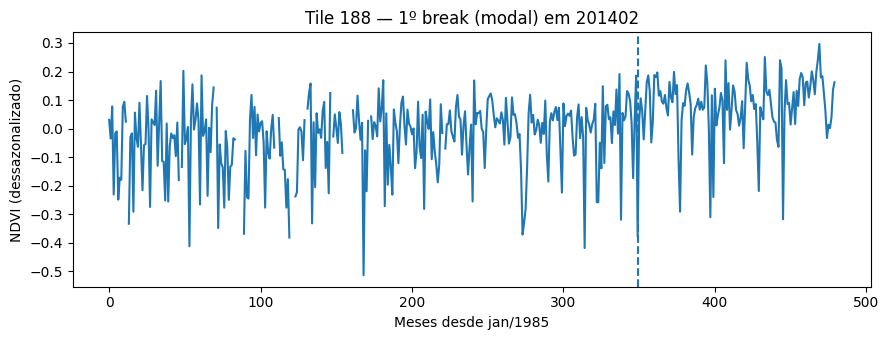

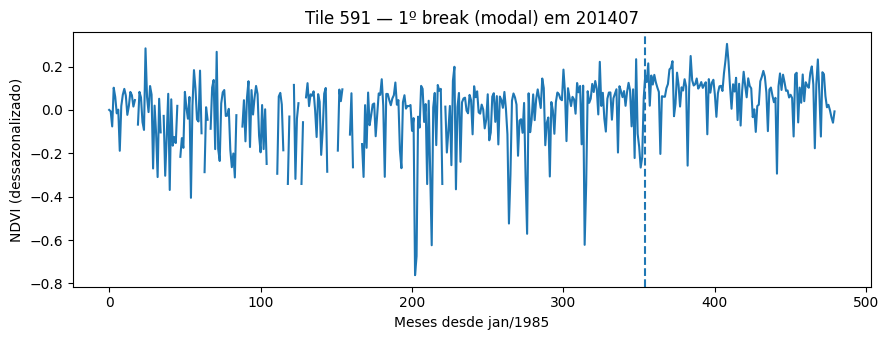

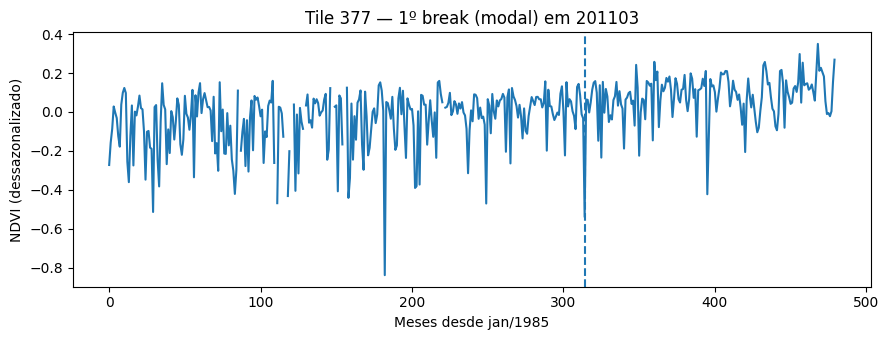

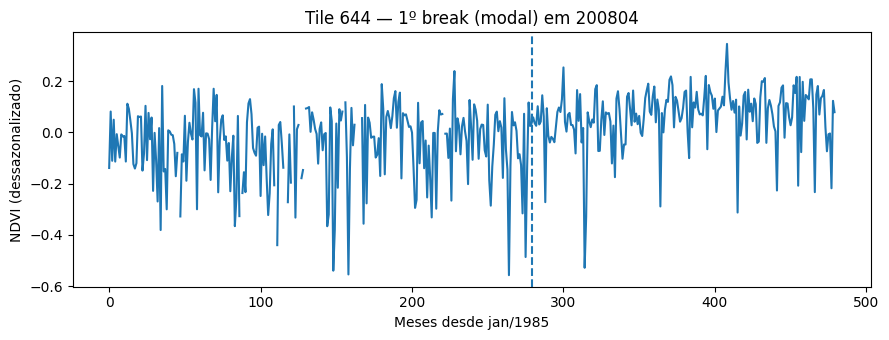

In [ ]:
from rasterio.windows import from_bounds

# --- Carrega df_sum de forma robusta (full run) ---
import pandas as pd
from pathlib import Path

CSV_SUM  = OUT_DIR / "tiles_with_breaks.csv"  # mesmo OUT_DIR do seu notebook

if 'df_sum' not in globals():
    if CSV_SUM.exists():
        df_sum = pd.read_csv(CSV_SUM)
    elif 'df_sum_s' in globals():  # fallback para o modo amostra, se existir
        df_sum = df_sum_s.copy()
    else:
        df_sum = pd.DataFrame()  # garante existência para não quebrar
# Se estamos em modo amostra, use a tabela de amostra como df_sum
if 'RUN_SAMPLE_ONLY' in globals() and RUN_SAMPLE_ONLY:
    if 'df_sum_s' in globals():
        df_sum = df_sum_s.copy()
    else:
        import pandas as pd
        df_sum = pd.DataFrame()  # garante existência

def plot_tile_series(tile_row, show_inline=True, save_png=True, debug=False):
    import numpy as np, pandas as pd, matplotlib.pyplot as plt
    from IPython.display import display

    # --- IDs/valores robustos ---
    try:
        tid = int(tile_row["tile_id"])
    except Exception:
        tid = int(float(tile_row["tile_id"]))
    val = tile_row.get("modal_yyyymm", 0)
    modal_ym = 0
    if val is not None:
        try:
            if not (isinstance(val, float) and np.isnan(val)):
                modal_ym = int(val)
        except Exception:
            modal_ym = 0

    # --- Reconstruir janela pelo BBOX salvo no df_sum ---
    minx = float(tile_row["minx"]); miny = float(tile_row["miny"])
    maxx = float(tile_row["maxx"]); maxy = float(tile_row["maxy"])
    win = from_bounds(minx, miny, maxx, maxy, transform=transform).round_offsets().round_lengths()
    if win.width <= 0 or win.height <= 0:
        if debug: print(f"[plot] tile {tid}: janela inválida")
        return None

    # --- Série mediana mensal do tile ---
    series = []
    for ds in datasets:
        arr = ds.read(indexes=list(range(1,13)), window=win).astype("float32")  # (12,h,w)
        mask = (arr == NODATA)
        arr[~mask] = arr[~mask] / DATA_SCALE
        arr[mask]  = np.nan
        med = np.nanmedian(arr.reshape(12, -1), axis=1)  # (12,)
        series.append(med)
    ser = np.concatenate(series)  # (T,)

    # dessazonaliza (anomalia mensal)
    ser_ds = ser.copy()
    for m in range(12):
        clim = np.nanmean(ser[m::12])
        ser_ds[m::12] = ser_ds[m::12] - clim

    # --- Eixo temporal ---
    y0 = years[0]
    T  = ser_ds.size
    years_axis  = np.array([years[i//12] for i in range(T)], dtype=np.int64)
    months_axis = np.array([1 + (i%12) for i in range(T)], dtype=np.int64)
    yyyymm_axis = (years_axis*100 + months_axis).astype(np.int64)

    # --- Plot (inline + opcional salvar) ---
    fig, ax = plt.subplots(figsize=(9, 3.5))
    ax.plot(range(T), ser_ds)
    title = f"Tile {tid} — "
    if modal_ym > 0:
        pos = np.where(yyyymm_axis == modal_ym)[0]
        if pos.size:
            ax.axvline(int(pos[0]), linestyle="--")
            title += f"1º break (modal) em {modal_ym}"
        else:
            title += f"modal {modal_ym} fora do eixo"
    else:
        title += "sem modal identificável"
    ax.set_title(title)
    ax.set_xlabel(f"Meses desde jan/{y0}")
    ax.set_ylabel("NDVI (dessazonalizado)")
    fig.tight_layout()

    outp = PLOTS_DIR / f"tile{tid:05d}_series.png"
    if save_png:
        fig.savefig(outp, dpi=150)
        if debug: print(f"[plot] salvo: {outp}")

    if show_inline:
        display(fig)  # <-- mostra no notebook

    plt.close(fig)
    return outp if save_png else None

if not df_sum.empty:
    df_sum["tile_id"] = df_sum["tile_id"].astype("int64", errors="ignore")
    df_sum["modal_yyyymm"] = df_sum["modal_yyyymm"].fillna(0).astype("int64", errors="ignore")

    top = df_sum.sort_values("frac_breaks", ascending=False).head(TOP_N_PLOTS)
    print("Top para plotar:\n", top[["tile_id","modal_yyyymm","frac_breaks"]])

    for _, row in top.iterrows():
        plot_tile_series(row, show_inline=True, save_png=True, debug=False)
else:
    print("df_sum está vazio — nada para plotar.")

In [ ]:
# ==== GRADE DE TILES → SHAPEFILE (e opcional: com métricas) ====
!pip -q install geopandas shapely fiona pyproj

import geopandas as gpd
from shapely.geometry import box

# 1) Monta a grade com a MESMA ordem/IDs do iter_windows (row-major)
def build_tile_index_gdf(tile_px=TILE_PX):
    feats = []
    for tid, win, meta in iter_windows(width, height, tile_px):
        col_off, row_off, win_w, win_h = meta
        minx, miny, maxx, maxy = tile_bounds(transform, col_off, row_off, win_w, win_h)
        geom = box(minx, miny, maxx, maxy)
        feats.append({
            "tile_id": int(tid),
            "col_off": int(col_off), "row_off": int(row_off),
            "win_w":   int(win_w),   "win_h":   int(win_h),
            "minx": float(minx), "miny": float(miny),
            "maxx": float(maxx), "maxy": float(maxy),
            "geometry": geom
        })
    return gpd.GeoDataFrame(feats, geometry="geometry", crs=ref.crs)

# 2) Cria a grade
gdf_tiles = build_tile_index_gdf(TILE_PX)
print("Tiles na grade:", len(gdf_tiles))

# 3) Salva a grade "pura" (SEM métricas) — ESRI Shapefile
tiles_shp = OUT_DIR / "tiles_index.shp"
gdf_tiles.to_file(tiles_shp)
print("Shapefile (grade) salvo em:", tiles_shp)

# 4) (OPCIONAL) Juntar métricas do CSV de resumo por tile e salvar outra camada
CSV_SUM = OUT_DIR / "tiles_with_breaks.csv"
if CSV_SUM.exists():
    df_sum = pd.read_csv(CSV_SUM)

    # Seleciona/renomeia colunas (Shapefile limita nomes a ~10 chars)
    cols_keep = ["tile_id","n_pixels","n_break_pixels","frac_breaks",
                 "earliest_yyyymm","latest_yyyymm","modal_year","modal_yyyymm"]
    dfj = df_sum.loc[:, [c for c in cols_keep if c in df_sum.columns]].copy()
    dfj = dfj.rename(columns={
        "n_break_pixels":"n_breakpx",
        "frac_breaks":"frac_break",
        "earliest_yyyymm":"early_ym",
        "latest_yyyymm":"late_ym",
        "modal_year":"modal_yr",
        "modal_yyyymm":"modal_ym"
    })

    # Join espacial por 'tile_id'
    gdf_join = gdf_tiles.merge(dfj, on="tile_id", how="left")

    # (Recomendado) também salvar em GeoPackage (mantém nomes longos e tipos)
    gpkg_path = OUT_DIR / "tiles_with_breaks.gpkg"
    gdf_join.to_file(gpkg_path, layer="tiles", driver="GPKG")
    print("GeoPackage (com métricas) salvo em:", gpkg_path)

    # E salvar também em Shapefile (para softwares que pedem .shp)
    shp_path = OUT_DIR / "tiles_with_breaks.shp"
    gdf_join.to_file(shp_path)
    print("Shapefile (com métricas) salvo em:", shp_path)
else:
    print("Aviso: CSV de métricas não encontrado — pulei o join.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 30.1 MB/s eta 0:00:00
Tiles na grade: 1040
Shapefile (grade) salvo em: /content/drive/MyDrive/Pantanal_TippingPoints_OFFLINE/tiles_index.shp
GeoPackage (com métricas) salvo em: /content/drive/MyDrive/Pantanal_TippingPoints_OFFLINE/tiles_with_breaks.gpkg
Shapefile (com métricas) salvo em: /content/drive/MyDrive/Pantanal_TippingPoints_OFFLINE/tiles_with_breaks.shp


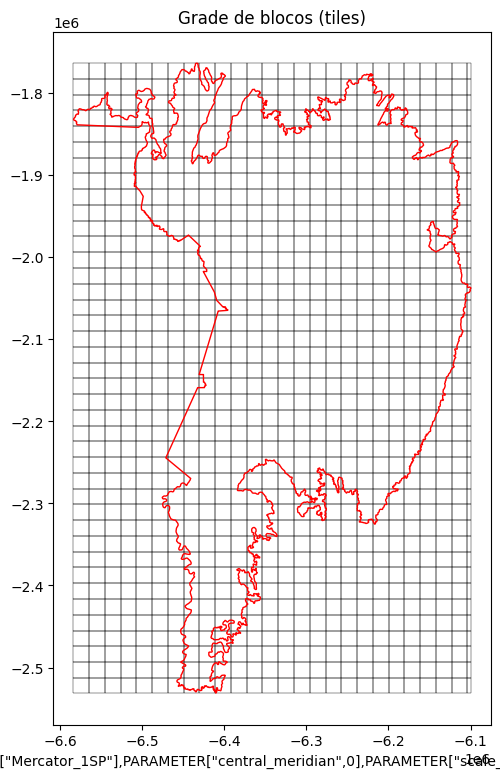

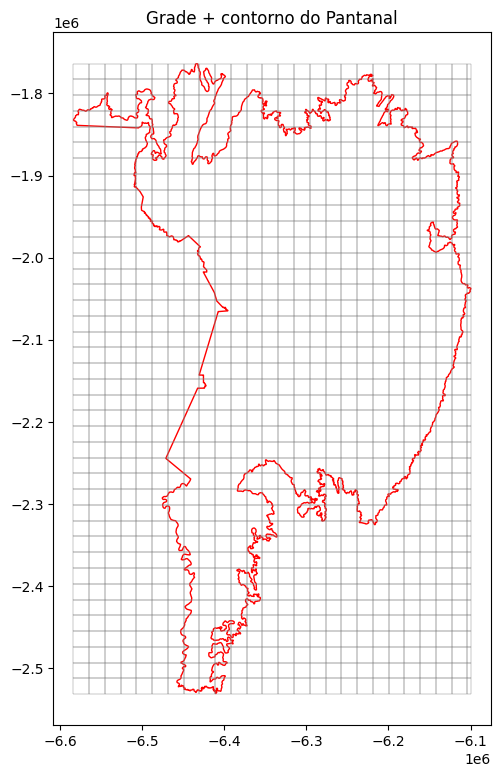

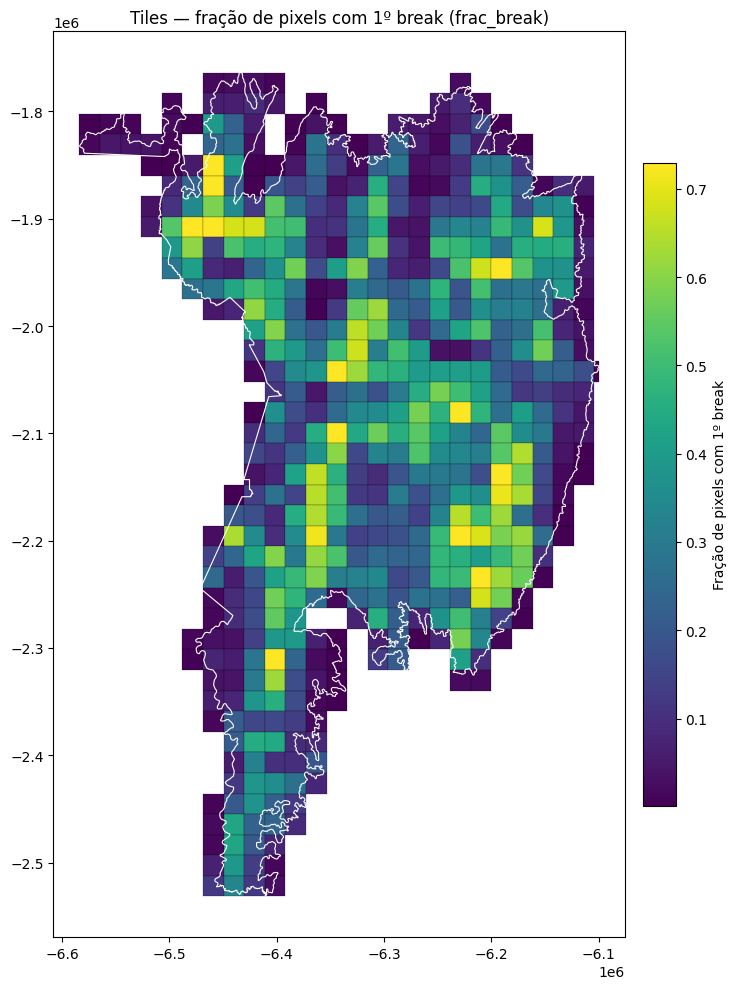

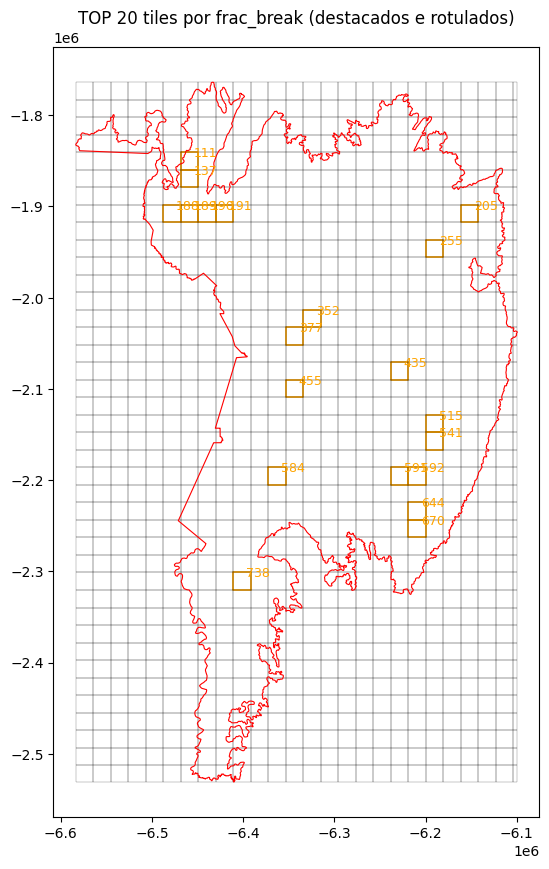

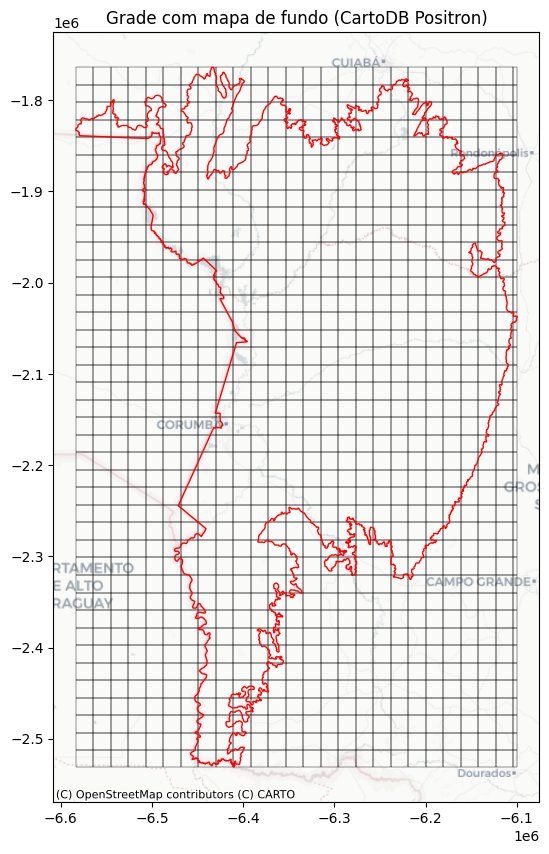

In [ ]:
# ==== PLOTAR A GRADE E OS RESULTADOS NO PRÓPRIO COLAB ====
!pip -q install geopandas shapely fiona pyproj matplotlib contextily

import os
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import box
from pathlib import Path
import pandas as pd
import numpy as np

# Caminhos
CSV_SUM   = OUT_DIR / "tiles_with_breaks.csv"
TILES_SHP = OUT_DIR / "tiles_index.shp"        # se você já salvou a grade
PANTANAL_SHP = Path("/content/drive/MyDrive/Pantanal/Pantanal.shp")  # se quiser sobrepor o contorno

# 1) Garantir a grade (gdf_tiles) na memória
def build_tile_index_gdf(tile_px=TILE_PX):
    feats = []
    for tid, win, meta in iter_windows(width, height, tile_px):
        col_off, row_off, win_w, win_h = meta
        minx, miny, maxx, maxy = tile_bounds(transform, col_off, row_off, win_w, win_h)
        feats.append({
            "tile_id": int(tid),
            "minx": float(minx), "miny": float(miny),
            "maxx": float(maxx), "maxy": float(maxy),
            "geometry": box(minx, miny, maxx, maxy)
        })
    return gpd.GeoDataFrame(feats, geometry="geometry", crs=ref.crs)

if 'gdf_tiles' not in globals():
    if TILES_SHP.exists():
        gdf_tiles = gpd.read_file(TILES_SHP)
    else:
        gdf_tiles = build_tile_index_gdf(TILE_PX)

# (Opcional) contorno do Pantanal
gdf_pant = None
if PANTANAL_SHP.exists():
    gdf_pant = gpd.read_file(PANTANAL_SHP)
    try:
        if gdf_pant.crs is None or gdf_pant.crs.to_epsg() != gdf_tiles.crs.to_epsg():
            gdf_pant = gdf_pant.to_crs(gdf_tiles.crs)
    except Exception:
        pass

# (Opcional) métrica por tile
gdf_join = gdf_tiles.copy()
if CSV_SUM.exists():
    df_sum = pd.read_csv(CSV_SUM)
    # nomes curtos pra evitar problemas futuros com shapefile
    cols = ["tile_id","n_break_pixels","frac_breaks","earliest_yyyymm","latest_yyyymm","modal_yyyymm"]
    dfj = df_sum.loc[:, [c for c in cols if c in df_sum.columns]].copy()
    dfj = dfj.rename(columns={"frac_breaks":"frac_break", "n_break_pixels":"n_breakpx",
                              "earliest_yyyymm":"early_ym", "latest_yyyymm":"late_ym",
                              "modal_yyyymm":"modal_ym"})
    gdf_join = gdf_join.merge(dfj, on="tile_id", how="left")

# -------- Plot 1: só a grade --------
ax = gdf_tiles.boundary.plot(figsize=(9,9), linewidth=0.3, color="black")
if gdf_pant is not None:
    gdf_pant.boundary.plot(ax=ax, color="red", linewidth=1.0)
ax.set_title("Grade de blocos (tiles)")
ax.set_xlabel(gdf_tiles.crs)
ax.set_ylabel("")
ax.set_aspect("equal")
plt.show()

# -------- Plot 2: grade + pantanal preenchido leve --------
ax = gdf_tiles.boundary.plot(figsize=(9,9), linewidth=0.3, color="grey")
if gdf_pant is not None:
    gdf_pant.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=1.0)
ax.set_title("Grade + contorno do Pantanal")
ax.set_aspect("equal")
plt.show()

# -------- Plot 3: mapa temático por frac_break --------
if "frac_break" in gdf_join.columns:
    v = gdf_join["frac_break"].astype(float)
    vmin, vmax = np.nanpercentile(v, [2, 98]) if np.isfinite(v).any() else (0.0, 1.0)
    fig, ax = plt.subplots(figsize=(10,10))
    gdf_join.plot(ax=ax, column="frac_break", cmap="viridis",
                  linewidth=0.15, edgecolor="k", vmin=vmin, vmax=vmax)
    if gdf_pant is not None:
        gdf_pant.boundary.plot(ax=ax, color="white", linewidth=0.8)

    # colorbar
    import matplotlib as mpl
    sm = mpl.cm.ScalarMappable(cmap="viridis", norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, fraction=0.035, pad=0.02)
    cbar.set_label("Fração de pixels com 1º break")

    ax.set_title("Tiles — fração de pixels com 1º break (frac_break)")
    ax.set_aspect("equal")
    plt.tight_layout()
    plt.show()

    # (Opcional) rotular os TOP 20 por frac_break
    top = gdf_join.sort_values("frac_break", ascending=False).head(20)
    if not top.empty:
        ax = gdf_join.boundary.plot(figsize=(10,10), linewidth=0.15, color="k")
        if gdf_pant is not None:
            gdf_pant.boundary.plot(ax=ax, color="red", linewidth=0.8)
        top.plot(ax=ax, facecolor="none", edgecolor="orange", linewidth=1.2)
        # rótulos no ponto representativo (evita rótulo fora do polígono)
        reps = top.representative_point()
        for (tid, geom) in zip(top["tile_id"], reps):
            ax.annotate(str(int(tid)), xy=(geom.x, geom.y), xytext=(3,3),
                        textcoords="offset points", fontsize=9, color="orange")
        ax.set_title("TOP 20 tiles por frac_break (destacados e rotulados)")
        ax.set_aspect("equal")
        plt.show()
else:
    print("Aviso: não encontrei 'frac_break' no join — rode o pós 1 para gerar tiles_with_breaks.csv.")

# -------- (Opcional) Adicionar mapa de fundo (requer internet no Colab) --------
try:
    import contextily as ctx
    ax = gdf_tiles.boundary.plot(figsize=(10,10), linewidth=0.3, color="black")
    # CRS precisa ser Web Mercator para os tiles de fundo (já está em EPSG:3857 no seu fluxo)
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf_tiles.crs.to_string())
    if gdf_pant is not None:
        gdf_pant.boundary.plot(ax=ax, color="red", linewidth=1.0)
    ax.set_title("Grade com mapa de fundo (CartoDB Positron)")
    ax.set_aspect("equal")
    plt.show()
except Exception as e:
    print("Basemap não adicionado (talvez sem internet no runtime):", e)
